In [2]:
import os
import numpy as np
import pandas as pd
from skimage import io
import json
os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv
from agrobrain_util.infra.app_config import application_config as cfg
from matplotlib.patches import Polygon as PolygonPatch
from skimage.util import crop


from agrobrain_image_processing.canopy.canopy import canopy_by_hsv
from agrobrain_canopy.canopy_cover.canopy_cover import CanopyCover

import shutil
import glob
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from functools import reduce
from shapely.geometry import Point, Polygon

import json
import random
import glob
import datetime
from tqdm import tqdm
from datetime import datetime
import pprint

from skimage.transform import resize
from skimage.filters import gaussian
import skimage.measure

from PIL import Image

import dtlpy as dl
if dl.token_expired():
    dl.login()

env = RuntimeEnv()

def download_datasets_annotations_from_dataloop(dataset_name, task_name="None", version=0):
    dataloop_local_data_dir = os.path.join(DATA_DIR, f"dataloop")
    annotation_local_path = os.path.join(dataloop_local_data_dir, f"annotations_{dataset_name}_task_{task_name}_v{version}")
    dataset = project.datasets.get(dataset_name=dataset_name)
    dataset.download_annotations(local_path=annotation_local_path)
    print(f"Done downloading annotations for the dataset: {dataset_name}.\n Local path: {annotation_local_path}")

def get_jsons_paths_list(dataset_name, task_name="None", version=0, sub_folder=""):
    dataloop_local_data_dir = os.path.join(DATA_DIR, f"dataloop")
    annotation_local_path = os.path.join(dataloop_local_data_dir, f"annotations_{dataset_name}_task_{task_name}_v{version}")
    if sub_folder=="":
        jsons_folder = os.path.join(annotation_local_path, "json")
    else:
        jsons_folder = os.path.join(annotation_local_path, "json", sub_folder)
    jsons_paths_list = glob.glob(os.path.join(jsons_folder, "*.json"))
    return jsons_paths_list

DATA_DIR = "data"

project = dl.projects.get(project_name='Taranis AI Annotation Projects')

# DOWNLOAD ANNOTATIONS

# ANNOTATIONS_DATASET_NAME = "anafa_2023_07_17_infestation_21_images"
ANNOTATIONS_DATASET_NAME = "anafa_tagging_methodology_1000_images_2023_07_24"


# download_datasets_annotations_from_dataloop(POINTS_DATASET_NAME)
annotations_jsons_paths_list = get_jsons_paths_list(ANNOTATIONS_DATASET_NAME)

label_colors_dict = {
    f'No weeds': 'red',
    f'Infestation.Up_to_10%': 'palegreen',
    f'Infestation.10%-25%': 'mediumseagreen',
    f'Infestation.25%-50%': 'seagreen',
    f'Infestation.50%-75%': 'green',
    f'Infestation.above_75%': 'darkgreen',

    f'Large_weeds.1-5': 'pink',
    f'Large_weeds.6-10': 'hotpink',
    f'Large_weeds.10+': 'deeppink',

    f'Small_weeds.Up_to_10': 'khaki',
    f'Small_weeds.above_10': 'gold'
    }

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables
could not find MONGO_DB_CONNECTION_STRING in environment variables


In [3]:
env.get_image_metadata(8471755)['orderID']
# 'orderID', 'fieldID', 'snapshotDate', 'cropName'
# Interesting images ids (wide): [im_id]

404108

In [13]:
# PRINT RANDOM IMAGE WITH ANNOTATIONS

def get_infestation_avg(box_labels):
     infestation_dict = {
         f"Infestation.Up_to_10%": 5,
         f"Infestation.10%-25%": 17.5,
         f"Infestation.25%-50%": 37.5,
         f"Infestation.50%-75%": 65.5,
         f"Infestation.above_75%": 87.5
     }
     labels_numbers = box_labels.replace(infestation_dict)
     return labels_numbers.mean()

def add_poly_box(boxes):
    for i, row in boxes.iterrows():
        x_values = [coord['x'] for coord in boxes['coordinates'][i]]
        y_values = [coord['y'] for coord in boxes['coordinates'][i]]
        minx, maxx = x_values
        miny, maxy = y_values
        bounding_box_coords = [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]
        boxes.at[i, 'box_poly'] = Polygon(bounding_box_coords)
    return boxes


def fit_points_to_boxes(boxes, labels):
    all_boxes_points_lists = []
    all_boxes_points_index_lists = []
    for i, box_row in boxes.iterrows():
        pt_list = []
        pt_index_list = []
        for j, label_row in labels.iterrows():
            x_value = int(label_row['coordinates']['x'])
            y_value = int(label_row['coordinates']['y'])
            shapely_point = Point(x_value, y_value)
            is_inside = box_row['box_poly'].contains(shapely_point)
            if is_inside:
                pt_list.append(shapely_point)
                pt_index_list.append(j)
        all_boxes_points_lists.append(pt_list)
        all_boxes_points_index_lists.append(pt_index_list)
    boxes["fitting_points"] = all_boxes_points_lists
    boxes["fitting_points_indexes"] = all_boxes_points_index_lists
    return boxes


def get_infestation_avg(box_labels):
     infestation_dict = {
         f"Infestation.Up_to_10%": 5,
         f"Infestation.10%-25%": 17.5,
         f"Infestation.25%-50%": 37.5,
         f"Infestation.50%-75%": 65.5,
         f"Infestation.above_75%": 87.5
     }
     labels_numbers = box_labels.replace(infestation_dict)
     return labels_numbers.mean()

def get_box_label_and_infestation_avg(box_df, labels):
    points_indexes = box_df['fitting_points_indexes']
    box_labels = labels.iloc[points_indexes]

    infestation_rows = box_labels[box_labels['label'].str.contains("Infestation")].index
    no_weeds_rows = box_labels[box_labels['label'].str.contains("No")].index

    if len(infestation_rows) > len(no_weeds_rows):
        infestation_avarage = get_infestation_avg(labels.iloc[infestation_rows]['label'])
        box_final_label = labels.iloc[infestation_rows]['label'].value_counts().idxmax()
        votes = labels.iloc[infestation_rows]['label'].value_counts().max()
    else:
        box_final_label = labels.iloc[no_weeds_rows]['label'].value_counts().idxmax()
        votes = labels.iloc[no_weeds_rows]['label'].value_counts().max()
        if len(infestation_rows) > 0:
            infestation_avarage = get_infestation_avg(labels.iloc[infestation_rows]['label'])
        else:
            infestation_avarage = 0
    return box_final_label, infestation_avarage, votes

def get_box_canopy_info(box_coordinates, index_canopy_image, hsv_canopy_image):
    x_values = [coord['x'] for coord in box_coordinates]
    y_values = [coord['y'] for coord in box_coordinates]
    minx, maxx = min(x_values), max(x_values)
    miny, maxy = min(y_values), max(y_values)

    cropped_image_hsv = crop(hsv_canopy_image, ((miny, hsv_canopy_image.shape[0] - maxy), (minx, hsv_canopy_image.shape[1] - maxx)))
    cropped_image_index_canopy = crop(index_canopy_image, ((miny, index_canopy_image.shape[0] - maxy), (minx, index_canopy_image.shape[1] - maxx)))

    box_size = cropped_image_hsv.shape[0] * cropped_image_hsv.shape[1]

    box_hsv_canopy_sum = np.count_nonzero(cropped_image_hsv)
    box_hsv_canopy_percent = round(box_hsv_canopy_sum/box_size, 2)
    box_canopy_index_sum = np.count_nonzero(cropped_image_index_canopy)
    box_canopy_index_percent = round(box_canopy_index_sum/box_size, 2)
    box_canopy_avg_hsv_index_sum = round(sum([box_hsv_canopy_sum, box_canopy_index_sum])/2, 2)
    return box_hsv_canopy_sum, box_hsv_canopy_percent, box_canopy_index_sum, box_canopy_index_percent, box_canopy_avg_hsv_index_sum

json_path = np.random.choice(annotations_jsons_paths_list)
with open(json_path) as file:
    json_data = json.load(file)

im_id = int(os.path.basename(json_path).replace(".json",""))
# im_id = 8484421
im_path = env.download_image(int(im_id))
image = io.imread(im_path)
print(f"calculating image {im_id} index canopy map...")
index_canopy_image = CanopyCover.canopy_cover(im_path)[0].astype(np.uint8) * 255
print(f"calculating image {im_id} hsv canopy map...")
hsv_canopy_image = canopy_by_hsv(image).astype(np.uint8) * 255


label_types = [json_data['annotations'][i]['label'] for i in range(len(json_data['annotations']))]
boxes = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] == 'annotation box']).reset_index(drop=True)
labels = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] != 'annotation box']).reset_index(drop=True)
boxes = add_poly_box(boxes)
boxes = fit_points_to_boxes(boxes, labels)

boxes["box_final_label"] = None
boxes["infestation_avarage"] = None
for i, box_row in tqdm(boxes.iterrows()):
    boxes.at[i, "image_id"] = im_id
    box_final_label, infestation_avarage, votes = get_box_label_and_infestation_avg(box_row, labels)
    boxes.at[i, "box_final_label"] = box_final_label
    boxes.at[i, "infestation_avarage"] = infestation_avarage
    boxes.at[i, "votes"] = votes
    box_hsv_canopy_sum, box_hsv_canopy_percent, box_canopy_index_sum, box_canopy_index_percent, box_canopy_avg_hsv_index_sum = get_box_canopy_info(box_row['coordinates'], index_canopy_image, hsv_canopy_image)
    boxes.at[i, "box_hsv_canopy_sum"] = box_hsv_canopy_sum
    boxes.at[i, "box_hsv_canopy_percent"] = box_hsv_canopy_percent
    boxes.at[i, "box_canopy_index_sum"] = box_canopy_index_sum
    boxes.at[i, "box_canopy_index_percent"] = box_canopy_index_percent
    boxes.at[i, "box_canopy_avg_hsv_index_sum"] = box_canopy_avg_hsv_index_sum



/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return np.asarray(imageio_imread(*args, **kwargs))


calculating image 8064409 index canopy map...
calculating image 8064409 hsv canopy map...


/usr/local/lib/python3.8/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.8/dist-packages/skimage/morphology/binary.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.empty(image.shape, dtype=np.bool)
0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/skimage/util/arraycrop.py:46: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_numpy = Version(np.__version__) < Version('1.16')
/usr/local/lib/python3.8/dist

In [15]:
boxes = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] == 'annotation box']).reset_index(drop=True)
labels = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] != 'annotation box']).reset_index(drop=True)
# boxes = add_poly_box(boxes)

In [18]:
# CREATE DATAFRAME FOR ALL BOXES FROM ALL THE IMAGES IN ORDER TO ANALYZE DATALOOP TAGGING

all_boxes = []
for json_path in annotations_jsons_paths_list:
    with open(json_path) as file:
        json_data = json.load(file)

    im_id = int(os.path.basename(json_path).replace(".json",""))
    im_path = env.download_image(int(im_id))
    # image = io.imread(im_path)
    # print(f"calculating image {im_id} index canopy map...")
    # index_canopy_image = CanopyCover.canopy_cover(im_path)[0].astype(np.uint8) * 255
    # print(f"calculating image {im_id} hsv canopy map...")
    # hsv_canopy_image = canopy_by_hsv(image).astype(np.uint8) * 255

    label_types = [json_data['annotations'][i]['label'] for i in range(len(json_data['annotations']))]
    boxes = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] == 'annotation box']).reset_index(drop=True)
    labels = pd.DataFrame([json_data['annotations'][i] for i in range(len(json_data['annotations'])) if json_data['annotations'][i]['label'] != 'annotation box']).reset_index(drop=True)
    boxes = add_poly_box(boxes)
    boxes = fit_points_to_boxes(boxes, labels)

    boxes["box_final_label"] = None
    boxes["infestation_avarage"] = None
    for i, box_row in tqdm(boxes.iterrows()):
        boxes.at[i, "image_id"] = im_id
        box_final_label, infestation_avarage, votes = get_box_label_and_infestation_avg(box_row, labels)
        boxes.at[i, "box_final_label"] = box_final_label
        boxes.at[i, "infestation_avarage"] = infestation_avarage
        boxes.at[i, "votes"] = votes
        # box_hsv_canopy_sum, box_hsv_canopy_percent, box_canopy_index_sum, box_canopy_index_percent, box_canopy_avg_hsv_index_sum = get_box_canopy_info(box_row['coordinates'], index_canopy_image, hsv_canopy_image)
        # boxes.at[i, "box_hsv_canopy_sum"] = box_hsv_canopy_sum
        # boxes.at[i, "box_hsv_canopy_percent"] = box_hsv_canopy_percent
        # boxes.at[i, "box_canopy_index_sum"] = box_canopy_index_sum
        # boxes.at[i, "box_canopy_index_percent"] = box_canopy_index_percent
        # boxes.at[i, "box_canopy_avg_hsv_index_sum"] = box_canopy_avg_hsv_index_sum
    all_boxes.append(boxes)
all_boxes_df = pd.concat(all_boxes, ignore_index=True)

10it [00:00, 539.20it/s]
10it [00:00, 628.76it/s]
10it [00:00, 517.45it/s]
10it [00:00, 680.66it/s]
10it [00:00, 481.50it/s]
10it [00:00, 602.69it/s]
10it [00:00, 617.84it/s]
10it [00:00, 570.00it/s]
10it [00:00, 563.59it/s]
10it [00:00, 581.03it/s]
10it [00:00, 503.54it/s]
10it [00:00, 542.39it/s]
10it [00:00, 549.37it/s]
10it [00:00, 579.91it/s]
10it [00:00, 517.52it/s]
10it [00:00, 514.74it/s]
10it [00:00, 628.49it/s]
10it [00:00, 723.19it/s]
10it [00:00, 687.74it/s]
10it [00:00, 603.35it/s]
10it [00:00, 240.80it/s]
10it [00:00, 726.80it/s]
10it [00:00, 703.21it/s]
10it [00:00, 703.84it/s]
10it [00:00, 448.98it/s]
10it [00:00, 617.98it/s]
10it [00:00, 577.32it/s]
10it [00:00, 562.50it/s]
10it [00:00, 679.70it/s]
10it [00:00, 658.56it/s]
10it [00:00, 685.78it/s]
10it [00:00, 646.87it/s]
10it [00:00, 763.32it/s]
10it [00:00, 662.90it/s]
10it [00:00, 546.59it/s]
10it [00:00, 717.26it/s]
10it [00:00, 755.89it/s]
10it [00:00, 657.48it/s]
10it [00:00, 673.06it/s]
10it [00:00, 574.27it/s]


ReadTimeout: HTTPConnectionPool(host='api-qa-us-central1.taranis', port=80): Read timed out. (read timeout=100)

In [19]:
all_boxes_df = pd.concat(all_boxes, ignore_index=True)

In [20]:
len(all_boxes_df)

6834

In [21]:
dl_annotations_infestation_1000_images_csv_path = os.path.join(DATA_DIR, "infestation_coverage", "dl_annotations_infestation_1000_images_analyze_partial.csv")
all_boxes_df.to_csv(dl_annotations_infestation_1000_images_csv_path)


In [22]:
all_boxes_df.columns
# 'votes', 'box_final_label'


Index(['id', 'datasetId', 'itemId', 'url', 'item', 'dataset', 'type', 'label',
       'attributes', 'coordinates', 'metadata', 'creator', 'createdAt',
       'updatedBy', 'updatedAt', 'hash', 'source', 'box_poly',
       'fitting_points', 'fitting_points_indexes', 'box_final_label',
       'infestation_avarage', 'image_id', 'votes', 'srcAnnotation'],
      dtype='object')

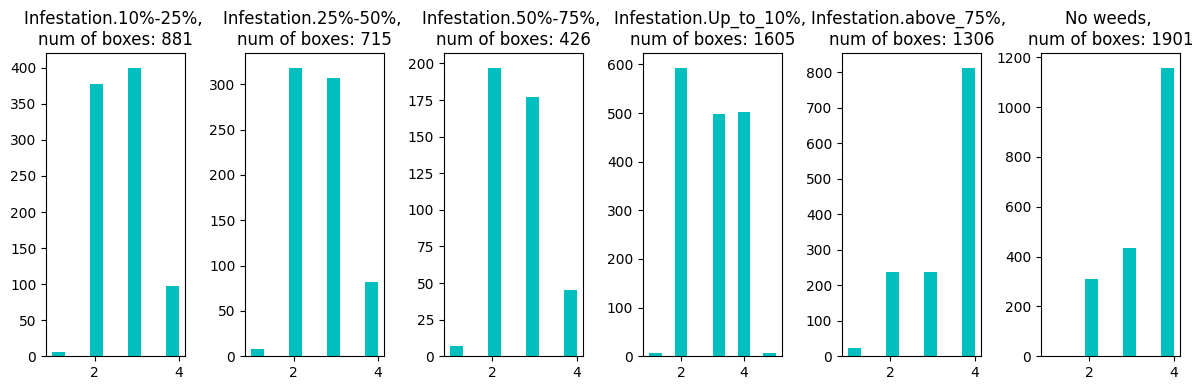

In [35]:
labels = np.unique(all_boxes_df['box_final_label'])
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))


for i, label in enumerate(labels):
    label_boxes = all_boxes_df[all_boxes_df['box_final_label']==label]
    axes[i].hist(label_boxes['votes'], color='c')
    axes[i].set_title(f"{label} \nnum of boxes: {len(label_boxes)}")

# plt.figsize
plt.tight_layout()
plt.show()



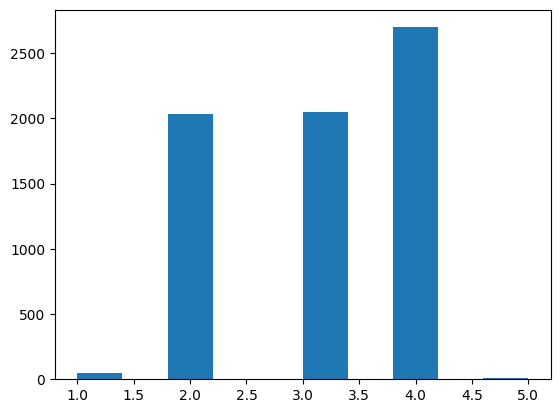

In [23]:
plt.hist(all_boxes_df['votes'])
plt.show()

# Show 

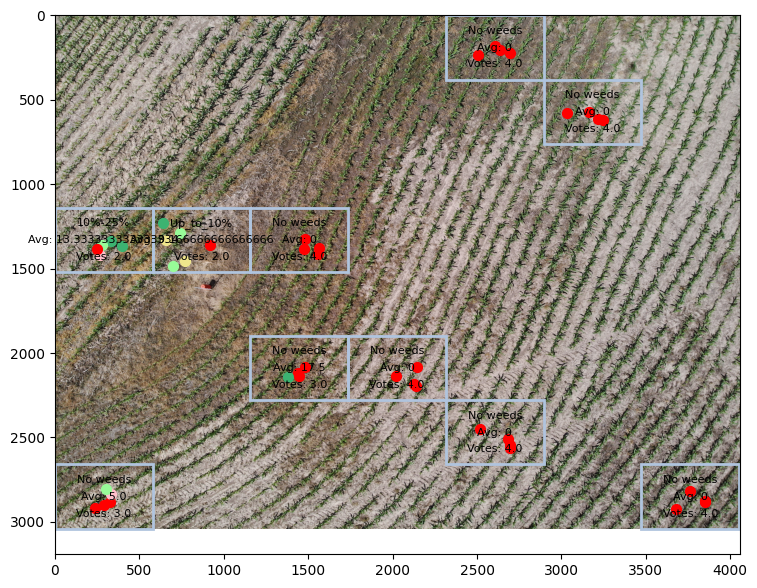

In [14]:
# SHOW

# im_id = int(os.path.basename(json_path).replace(".json",""))
# im_path = env.download_image(int(im_id))
# image = io.imread(im_path)
# index_canopy_image = CanopyCover.canopy_cover(im_path)[0].astype(np.uint8) * 255
# hsv_canopy = canopy_by_hsv(im).astype(np.uint8) * 255

fig, ax = plt.subplots(figsize=(14,7))
ax.imshow(image)

# SHOW BOXES 

for i in range(len(boxes['coordinates'])):
    x_values = [coord['x'] for coord in boxes['coordinates'][i]]
    y_values = [coord['y'] for coord in boxes['coordinates'][i]]
    minx, maxx = x_values
    miny, maxy = y_values
    bounding_box_coords = [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]
    bounding_box = Polygon(bounding_box_coords)
    box_patch = PolygonPatch(np.array(bounding_box.exterior.coords), facecolor='none', edgecolor='lightsteelblue', linewidth=2)
    ax.add_patch(box_patch)

    text1_x = (minx + maxx) / 2
    text1_y = (miny + maxy) / 2 - 100
    text2_y = (miny + maxy) / 2
    text3_y = (miny + maxy) / 2 + 100
    text_1 = f"{boxes['box_final_label'][i]}".replace("Infestation.", "")
    text_2 = f"Avg: {boxes['infestation_avarage'][i]}"
    text_3 = f"Votes: {boxes['votes'][i]}"
    ax.text(text1_x, text1_y, text_1, color='black', fontsize=8, ha='center', va='center')
    ax.text(text1_x, text2_y, text_2, color='black', fontsize=8, ha='center', va='center')
    ax.text(text1_x, text3_y, text_3, color='black', fontsize=8, ha='center', va='center')



# SHOW POINTS - LABELS
for i in range(len(labels)):
    x_value = int(labels['coordinates'][i]['x'])
    y_value = int(labels['coordinates'][i]['y'])
    color = label_colors_dict[labels['label'][i]]
    ax.scatter(x_value, y_value, color=color, s=50)

plt.show()

/usr/local/lib/python3.8/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.8/dist-packages/skimage/morphology/binary.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.empty(image.shape, dtype=np.bool)


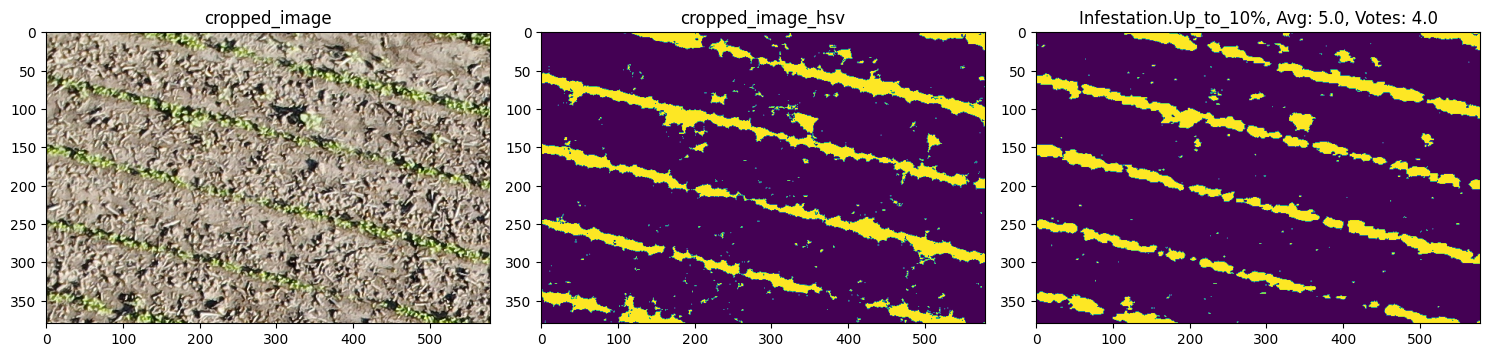

In [309]:
# SHOW CROPPED BOX - ORIGINAL IMAGE AND TWO CANOPY COVER MAPS

from skimage import io
from skimage.util import crop

index_canopy_image = CanopyCover.canopy_cover(im_path)[0].astype(np.uint8) * 255
hsv_canopy = canopy_by_hsv(image).astype(np.uint8) * 255


BOX_NUM = 3

coords = boxes['coordinates'][BOX_NUM]

# coords
# Extract coordinates
x_values = [coord['x'] for coord in coords]
y_values = [coord['y'] for coord in coords]

# Calculate the bounding box
minx, maxx = min(x_values), max(x_values)
miny, maxy = min(y_values), max(y_values)

# Crop the image
cropped_image = crop(image, ((miny, image.shape[0] - maxy), (minx, image.shape[1] - maxx), (0, 0)))
cropped_image_hsv = crop(hsv_canopy, ((miny, image.shape[0] - maxy), (minx, image.shape[1] - maxx)))
cropped_image_index_canopy = crop(index_canopy_image, ((miny, image.shape[0] - maxy), (minx, image.shape[1] - maxx)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cropped_image)
axes[0].set_title("cropped_image")

axes[1].imshow(cropped_image_hsv)
axes[1].set_title("cropped_image_hsv")

axes[2].imshow(cropped_image_index_canopy)
axes[2].set_title("cropped_image_index_canopy")

plt.title(f"{boxes['box_final_label'][BOX_NUM]}, Avg: {boxes['infestation_avarage'][BOX_NUM]}, Votes: {boxes['votes'][BOX_NUM]}")
plt.tight_layout()
plt.show()